# Week 3 Assignment

## Summary:

For this week's assignment, I chose additional story excerpts from the [Grimms' Fairy Tales](http://www.gutenberg.org/ebooks/2591), written by Jacob Grimm and Wilhelm Grimm, and pickled them into a file. The stories in the pickled file are "The Twelve Dancing Princesses" (from Week 1 assignment), "Cat-Skin", "The Fisherman and His Wife", "The Frog-Prince", "Snowdrop", and "The Twelve Huntsmen". 

A few modifications were made to the `cleanCorpus` function to process text before analysis. First, I removed the `lemmatize` argument for the function, since one of the exercises calls for POS-tagging and therefore I wanted to leave words in their "natural" state for better results. After the function lowercases the text and removes punctuation, it then tokenizes the text, removes stopwords, and stems the remaining words using the `SnowballStemmer` function. I arranged the removal of stopwords to come before stemming so that words like "was" would not be stemmed in such a way that they were no longer recognizable as a stopword and not removed from the text. I chose to replace `PorterStemmer` with `SnowballStemmer` just to compare results and see if I get more signal from the text.

In [1]:
import pickle as pk
import string
import spacy
import pandas as pd
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk import pos_tag
from nltk.util import ngrams
from nltk import edit_distance

from pylab import *

from scipy.stats import zipf

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer


en_stopwords = stopwords.words('english')  
stopwords = set(en_stopwords)

stemmer = SnowballStemmer('english')

nlp = spacy.load("en_core_web_sm")

%matplotlib inline

In [2]:
#function to lowercase, remove punctuation/digits, tokenize (split into words), remove stopwords, then stem
def cleanCorpus(corpus, doc_num=1):
    
    clean_document = []
    
    for doc in corpus:
        
        #make all words lowercased
        lowercased = doc.lower()
        
        #remove punctuation and digits
        table = str.maketrans({key: None for key in string.punctuation + string.digits + "‘" + "’"})
        nopunct_digits = lowercased.translate(table)
        
        #make a list of word tokens
        tknzls = word_tokenize(nopunct_digits)
        
        #remove stopwords and then stem remaining words
        #cleanwls is a list
        cleanwls = []
        
        for token in tknzls:
            if token not in stopwords:
                
                #stem word then add to list
                cleanwls.append(stemmer.stem(token))
                
                
        #join list of cleaned words together into one string
        clean_str = " ".join(cleanwls)
        
        #add string as list item
        clean_document.append(clean_str)
        
        #confirmation for each document number cleaned
        print("Document {} cleaned".format(doc_num))
        doc_num += 1
    
    #returned output is a list with each document item from corpus as a string
    return clean_document

In [3]:
#load corpus as list with each document as list item
#each document is a string
grimm_corpus = pk.load(open('grimms_tales.pk', 'rb'))

In [4]:
#number of documents in the corpus
len(grimm_corpus)

6

In [5]:
#first 20 characters of 1st document in corpus
grimm_corpus[0][:20]

'THE TWELVE DANCING P'

In [6]:
#clean_grimm is a list
#each list item is a string value for each document
clean_grimm = cleanCorpus(grimm_corpus)

Document 1 cleaned
Document 2 cleaned
Document 3 cleaned
Document 4 cleaned
Document 5 cleaned
Document 6 cleaned


In [7]:
#first 50 characters in first document in list
clean_grimm[0][:50]

'twelv danc princess king twelv beauti daughter sle'

In [8]:
#grimm_tknz is a list of all tokens in corpus
#will iterate through each story and extract tokens
#will put into single list, each token is an item
grimm_tknz = [token for story in clean_grimm for token in word_tokenize(story)]

In [9]:
#verify tokens in list
grimm_tknz[:5]

['twelv', 'danc', 'princess', 'king', 'twelv']

In [10]:
#number of words in whole corpus (after cleaning)
len(grimm_tknz)

4536

In [11]:
#grimm_doc_tknz is a list
#each list item is document
#items in document is list of document's tokens
grimm_doc_tknz = [word_tokenize(story) for story in clean_grimm]

In [12]:
#number of documents in list
len(grimm_doc_tknz)

6

In [13]:
#first 5 items (tokens) in 1st document in list
grimm_doc_tknz[0][:5]

['twelv', 'danc', 'princess', 'king', 'twelv']

### POS Tagging

In this exercise, I tried two different methods for part-of-speech tagging. The first method used the NLTK library `pos_tag` function. For the `pos_tag` function, I passed a list of all the corpus tokens through a loop and then created a new list that contained each token paired with its part-of-speech tag.

For the spaCy library, I had to take the cleaned corpus and transform it into a spaCy object, which contains word tokens from the corpus. Then I used `.text` to get the word token string and `.pos_` to get the POS tag, and stored the pairing into a list. 

In [14]:
#pos tagging for each story
#pos_grimm is a list
#items in list are each document
#each document contains list with items that are tuple values of tokens with POS tag
pos_grimm = []

for story in grimm_doc_tknz:
    pos_grimm.append(pos_tag(story))

In [15]:
#first 5 POS tagged tokens in first document
pos_grimm[0][:5]

[('twelv', 'NN'),
 ('danc', 'NN'),
 ('princess', 'NN'),
 ('king', 'VBG'),
 ('twelv', 'JJ')]

In [16]:
#spaCy POS-tagging

#empty list to hold each document of POS-tagged tokens
nlp_pos = []

#use each document string value from clean_grimm
for doc in clean_grimm:
    
    #spaCy nlp function will tokenize the string
    tknzdoc = nlp(doc)
    
    #empty list to hold document's POS-tagged tokens
    doc_pos = []
    
    #get token text and token POS, store as a tuple value
    #append tuple to doc_pos list
    for token in tknzdoc:
        doc_pos.append((token.text, token.pos_))
    
    #append each document list of token+POS tuples to nlp_pos list
    nlp_pos.append(doc_pos)

In [17]:
#number of POS-tagged documents in list
len(nlp_pos)

6

In [18]:
#first 5 POS tagged tokens in first document
nlp_pos[0][:5]

[('twelv', 'VERB'),
 ('danc', 'ADJ'),
 ('princess', 'NOUN'),
 ('king', 'NOUN'),
 ('twelv', 'VERB')]

### N-grams

For this section, I created lists that contained 2-grams, 3-grams, and 4-grams from the corpus. The `corpus_` list for each n-gram type was created to hold the n-grams within each document. However, in order to compare the frequency of all similar n-grams to each other (across the entire corpus), I made a list for all the n-gram tokens, not separated by document. These lists were then used to calculate the top 20 frequently occuring n-grams of its type.

Then using the frequency distribution of all the bigrams, I made a `pandas` dataframe and used the `'count'` column for the Zipf plot frequencies. With code from a [Twitter sentiment analysis tutorial](https://towardsdatascience.com/another-twitter-sentiment-analysis-with-python-part-3-zipfs-law-data-visualisation-fc9eadda71e7) and the [Week 3 assignment video walkthrough](https://www.youtube.com/watch?v=KwIp_73ndeI&feature=youtu.be), I made adjustments for the counts, tokens, and plot point labels in the Zipf plot output.

In [19]:
#n-grams for each doc

#lists will hold list of n-grams for each document
corpus_bgs = []
corpus_tgs = []
corpus_fgs = []

for doc in grimm_doc_tknz:
    
    #make n-grams list for each document
    bgs = [bigram for bigram in ngrams(doc, 2)]
    tgs = [trigram for trigram in ngrams(doc, 3)]
    fgs = [fourgram for fourgram in ngrams(doc, 4)]
    
    #append each document's n-gram list to full corpus list
    corpus_bgs.append(bgs)
    corpus_tgs.append(tgs)
    corpus_fgs.append(fgs)

In [20]:
#number of documents in list
#each list item contains list of document's bigrams
len(corpus_bgs)

6

In [21]:
#first 5 bigrams in first document of corpus_bgs
corpus_bgs[0][:5]

[('twelv', 'danc'),
 ('danc', 'princess'),
 ('princess', 'king'),
 ('king', 'twelv'),
 ('twelv', 'beauti')]

In [22]:
#list of all n-grams in corpus (each n-gram is an item)
all_bgs = [bgs_token for storybgs in corpus_bgs for bgs_token in storybgs]
all_tgs = [tgs_token for storytgs in corpus_tgs for tgs_token in storytgs]
all_fgs = [fgs_token for storyfgs in corpus_fgs for fgs_token in storyfgs]

In [23]:
#number of items in each n-grams list
print(len(all_bgs))
print(len(all_tgs))
print(len(all_fgs))

4530
4524
4518


In [24]:
#Top 20 bigrams
FreqDist(all_bgs).most_common(20)

[(('said', 'fish'), 11),
 (('king', 'said'), 10),
 (('king', 'daughter'), 9),
 (('said', 'man'), 9),
 (('said', 'fisherman'), 9),
 (('went', 'home'), 8),
 (('open', 'door'), 8),
 (('old', 'woman'), 7),
 (('said', 'king'), 7),
 (('said', 'wife'), 7),
 (('wife', 'ilsabil'), 7),
 (('ah', 'said'), 7),
 (('wife', 'said'), 7),
 (('twelv', 'huntsmen'), 7),
 (('take', 'care'), 6),
 (('long', 'time'), 6),
 (('fisherman', 'went'), 6),
 (('man', 'sea'), 6),
 (('sea', 'hearken'), 6),
 (('hearken', 'wife'), 6)]

In [25]:
#Top 20 trigrams
FreqDist(all_tgs).most_common(20)

[(('man', 'sea', 'hearken'), 6),
 (('sea', 'hearken', 'wife'), 6),
 (('hearken', 'wife', 'ilsabil'), 6),
 (('wife', 'ilsabil', 'hath'), 6),
 (('ilsabil', 'hath', 'sent'), 6),
 (('hath', 'sent', 'beg'), 6),
 (('sent', 'beg', 'boon'), 6),
 (('beg', 'boon', 'thee'), 6),
 (('go', 'home', 'said'), 6),
 (('home', 'said', 'fish'), 6),
 (('thou', 'queen', 'art'), 5),
 (('said', 'man', 'sea'), 4),
 (('ah', 'said', 'fisherman'), 4),
 (('wife', 'said', 'fisherman'), 4),
 (('said', 'fish', 'ah'), 4),
 (('fish', 'ah', 'said'), 4),
 (('queen', 'art', 'fairest'), 4),
 (('king', 'twelv', 'huntsmen'), 4),
 (('fisherman', 'went', 'home'), 3),
 (('want', 'said', 'fish'), 3)]

In [26]:
#Top 20 4-grams
FreqDist(all_fgs).most_common(20)

[(('man', 'sea', 'hearken', 'wife'), 6),
 (('sea', 'hearken', 'wife', 'ilsabil'), 6),
 (('hearken', 'wife', 'ilsabil', 'hath'), 6),
 (('wife', 'ilsabil', 'hath', 'sent'), 6),
 (('ilsabil', 'hath', 'sent', 'beg'), 6),
 (('hath', 'sent', 'beg', 'boon'), 6),
 (('sent', 'beg', 'boon', 'thee'), 6),
 (('go', 'home', 'said', 'fish'), 6),
 (('said', 'man', 'sea', 'hearken'), 4),
 (('said', 'fish', 'ah', 'said'), 4),
 (('thou', 'queen', 'art', 'fairest'), 4),
 (('want', 'said', 'fish', 'ah'), 3),
 (('said', 'open', 'door', 'princess'), 3),
 (('open', 'door', 'princess', 'dear'), 3),
 (('door', 'princess', 'dear', 'open'), 3),
 (('princess', 'dear', 'open', 'door'), 3),
 (('dear', 'open', 'door', 'thi'), 3),
 (('open', 'door', 'thi', 'true'), 3),
 (('door', 'thi', 'true', 'love'), 3),
 (('thi', 'true', 'love', 'mind'), 3)]

In [27]:
bgs_freq = FreqDist(all_bgs).most_common()

In [28]:
ngrams = []
freq = []

for item in bgs_freq:
    ngrams.append(str(item[0]))
    freq.append(item[1])
    
ngramls = list(zip(ngrams, freq))

In [29]:
ngram_df = pd.DataFrame(ngramls, columns=['ngram', 'count'])
ngram_df.head()

,ngram,count
0,"('said', 'fish')",11
1,"('king', 'said')",10
2,"('king', 'daughter')",9
3,"('said', 'man')",9
4,"('said', 'fisherman')",9


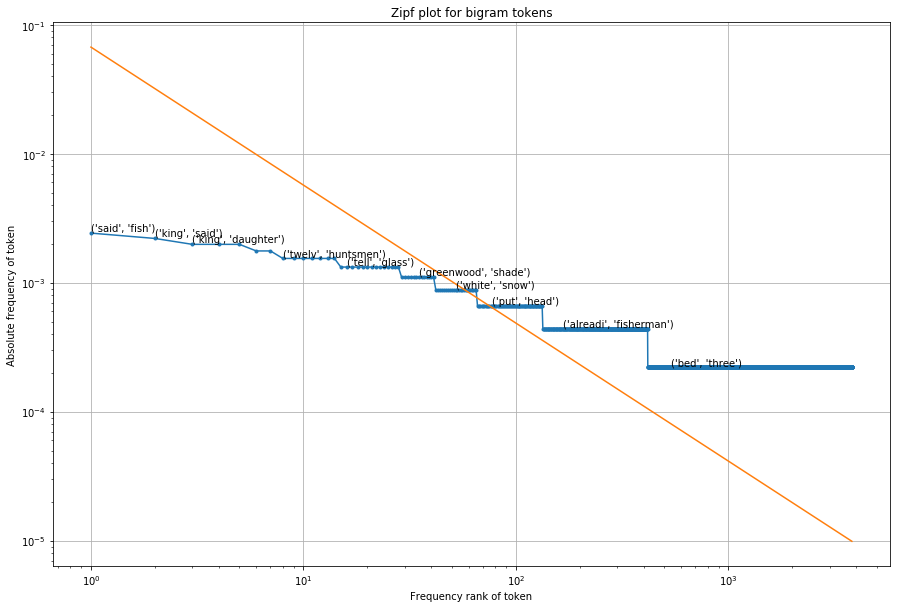

In [30]:
'''
Zipfian plot of bigrams
'''

#
counts = ngram_df['count']

#get index number for each token
tokens = ngram_df.index

ranks = arange(1, len(counts)+1)
indices = argsort(-counts)
frequencies = counts[indices]

norm_freq = frequencies/sum(counts)

plt.figure(figsize=(15,10))

loglog(ranks, norm_freq, marker=".")

plt.plot(ranks, [z for z in zipf.pmf(ranks, 1.07)])


title("Zipf plot for bigram tokens")
xlabel("Frequency rank of token")
ylabel("Absolute frequency of token")

grid(True)

last_freq = None

for n in list(logspace(-0.5, log10(len(counts)-2), 25).astype(int)):
    if last_freq != norm_freq[n]:
        dummy = text(ranks[n], norm_freq[n], ngram_df['ngram'].iloc[tokens[indices[n]]], 
                     verticalalignment="bottom",
                     horizontalalignment="left")
    last_freq = norm_freq[n]

### Word Cloud

Using the bigrams in the corpus, I made a dictionary of bigrams and their frequency. In order to see the bigram pairs more clearly in the word cloud (as some smaller tokens may appear between larger tokens), I combined the words separated by an underscore (as inspired by [this blog post](https://avidml.wordpress.com/2017/08/03/word-cloud-with-frequently-occurring-bigrams-and-salient-bigrams/)). Then I applied the dictionary within the `WordCloud` function to create the output of bigram pair frequency represented by font size.

In [31]:
bgs_str_freq = {}

for bgs_tuple in bgs_freq:
    
    v = bgs_tuple[1]
    
    k = "_".join([bgs_tuple[0][0], bgs_tuple[0][1]])
        
    bgs_str_freq[k] = v

In [31]:
bgs_str_freq = {}

for bgs_tuple in bgs_freq:
    
    v = bgs_tuple[1]
    
    k = bgs_tuple[0]
        
    bgs_str_freq[k] = v

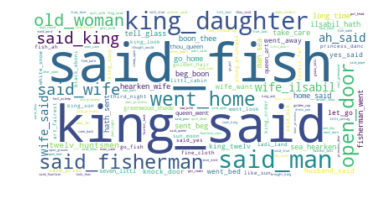

In [32]:
#generate word cloud image
wordcloud = WordCloud(background_color="white").generate_from_frequencies(bgs_str_freq)
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Similarity

In this exercise, I chose to create a list of the top 10 frequently occuring bigrams and wanted to compare the similarity of each to the top occuring bigram, "said fish". From the NLTK library, I used the `edit_distance` function to calculate Levenshtein Distance between the "said fish" bigram and the other bigram pairs.

In [33]:
disls = []

for bgs_tuple in bgs_freq:
    
    k = " ".join([bgs_tuple[0][0], bgs_tuple[0][1]])
        
    disls.append(k)

In [34]:
dis10 = disls[:10]

In [35]:
query = 'said fish'

for bigram in dis10:
    
    distance = edit_distance(query, bigram)
    
    print("Edit Distance for {0} and {1}: {2}".format(query, bigram, distance))

Edit Distance for said fish and said fish: 0
Edit Distance for said fish and king said: 8
Edit Distance for said fish and king daughter: 11
Edit Distance for said fish and said man: 4
Edit Distance for said fish and said fisherman: 5
Edit Distance for said fish and went home: 8
Edit Distance for said fish and open door: 8
Edit Distance for said fish and old woman: 8
Edit Distance for said fish and said king: 3
Edit Distance for said fish and said wife: 3


## Conclusion:

I think that modifying the `cleanCorpus` function and using the `SnowballStemmer` function helped improve the quality of the text for analysis. I did not notice any strangely transformed word tokens and stemmed words seemed to retain their overall meaning. 

It was interesting to find that the NLTK `pos_tag` function and the spaCy `.pos_` function categorized the part-of-speech different for several words. However, from looking at the first 5 POS-tagged tokens from the text, both functions did not tag the words very well. For example, "danc" (dance) was labeled as a noun in NLTK but an adjective by spaCy when in reality, "danc" was used a verb ("the twelve dancing princesses"). This is where word level ambiguity makes it difficult to properly label text, because NLTK's interpretation is based on the noun usage of "dance" ("I am going to the dance tonight.") whereas the spaCy interpretation seemed to label it as a description of the princesses. In future analysis, I wonder if using parsing part-of-speech by sentence tokens would give better context to properly label words.

Based on the output of the Top 20 bigrams, there seems to be a lot of dialogue within the documents in the corpus; the word "said" is paired frequently with other tokens in a bigram. The trigrams give a bit more insight into text outside of each story's dialogue but I found 4-grams to be generally useless in this analysis, since the information extracted was a near match to the trigram sets.

Also noting the trend of dialogue in the corpus, the "said fish" bigram was found to be most similar to bigrams that also started with the word "said" and had the same bigram character length (9 characters, including the space). Other bigrams that were close in similarity were also dialogue-based (started with "said") but had differing character lengths.

***

# Bonus Exercises

### Frequent Nouns and Verbs

Using the spaCy `.pos_` function, I collected a list of tokens and their POS tag, then stored them in lists for nouns or verbs if their POS matched. Then with the lists of nouns and verbs, I calculated the frequency distribution for each and returned the top 10 most frequently occuring nouns and verbs. Many of the top verbs are characters in the stories (king, princess, wife, queen) while the most frequent verbs were dialogue (said) or movement-based (went, came, go).

In [36]:
#spaCy POS-tagging

#empty list to hold each document of POS-tagged tokens
spcy_pos = []

#use each document string value from clean_grimm
for doc in clean_grimm:
    
    #spaCy nlp function will tokenize the string
    tknzdoc = nlp(doc)
    
    #get token text and token POS, store as a tuple value
    #append tuple to doc_pos list
    for token in tknzdoc:
        
        #append each document list of token+POS tuples to nlp_pos list
        spcy_pos.append((token.text, token.pos_))

In [37]:
len(spcy_pos)

4543

In [38]:
spcy_pos[:5]

[('twelv', 'VERB'),
 ('danc', 'ADJ'),
 ('princess', 'NOUN'),
 ('king', 'NOUN'),
 ('twelv', 'VERB')]

In [39]:
nouns = []
verbs = []

for token in spcy_pos:
    
    if token[1] == "NOUN":
        nouns.append(token[0])
    elif token[1] == "VERB":
        verbs.append(token[0])

In [40]:
FreqDist(nouns).most_common(10)

[('king', 99),
 ('wife', 47),
 ('princess', 43),
 ('snowdrop', 35),
 ('time', 26),
 ('fisherman', 26),
 ('queen', 25),
 ('fish', 25),
 ('door', 24),
 ('beauti', 21)]

In [41]:
FreqDist(verbs).most_common(10)

[('said', 163),
 ('went', 64),
 ('came', 48),
 ('go', 39),
 ('put', 25),
 ('could', 24),
 ('look', 24),
 ('let', 24),
 ('would', 22),
 ('see', 20)]

## Zipf Plot

Similar to the earlier Zipfian distribution plot for bigrams in the corpus, I created dataframes for the trigrams/4-grams and their frequency count. Then using the dataframe for each n-gram type, I modified the plot code for `counts`, `tokens`, and the `dummy`. Unlike the bigram plot, the trigram and 4-gram plots did not show the trigram/4-gram labels in an informative way. On the first try of the trigram plot, only the first trigram label ("sea harken wife") shows. Yet when I remove the `if last_freq != norm_freq[n]` condition along with the `last_freq = norm_freq[n]` statement, then all the trigram labels show but it is very clutter and illegible. Nonetheless, the Zipfian distribution of the trigrams compared to the 4-grams supports my earlier conclusion that there is not much additional insight gained from creating larger n-grams after three-word sequences.

In [42]:
str_gram = []
freqls = []

#add trigram and frequency count to lists
for ngram, freq in FreqDist(all_tgs).items():
    
    str_gram.append(" ".join(ngram))
    freqls.append(freq)

In [43]:
#verify trigram output
str_gram[:5]

['twelv danc princess',
 'danc princess king',
 'princess king twelv',
 'king twelv beauti',
 'twelv beauti daughter']

In [44]:
#zip trigram and frequency lists
#combine into one list
tgls = list(zip(str_gram, freqls))

In [45]:
#create dataframe of trigrams and frequency count
tg_df = pd.DataFrame(tgls, columns=['ngram', 'count'])
tg_df.head()

,ngram,count
0,twelv danc princess,1
1,danc princess king,1
2,princess king twelv,1
3,king twelv beauti,1
4,twelv beauti daughter,1


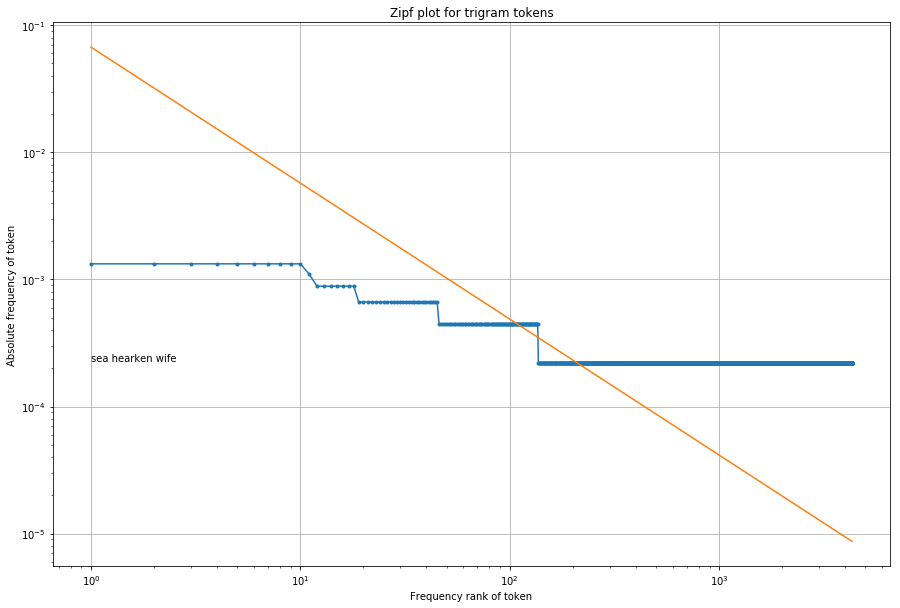

In [46]:
'''
Zipfian plot of trigrams
'''

#
counts = tg_df['count']

#get index number for each token
tokens = tg_df.index

ranks = arange(1, len(counts)+1)
indices = argsort(-counts)
frequencies = counts[indices]

norm_freq = frequencies/sum(counts)

plt.figure(figsize=(15,10))

loglog(ranks, norm_freq, marker=".")

plt.plot(ranks, [z for z in zipf.pmf(ranks, 1.07)])


title("Zipf plot for trigram tokens")
xlabel("Frequency rank of token")
ylabel("Absolute frequency of token")

grid(True)

last_freq = None

for n in list(logspace(-0.5, log10(len(counts)-2), 25).astype(int)):
    if last_freq != norm_freq[n]:
        dummy = text(ranks[n], norm_freq[n], tg_df['ngram'].iloc[tokens[indices[n]]], 
                     verticalalignment="bottom",
                     horizontalalignment="left")
    last_freq = norm_freq[n]

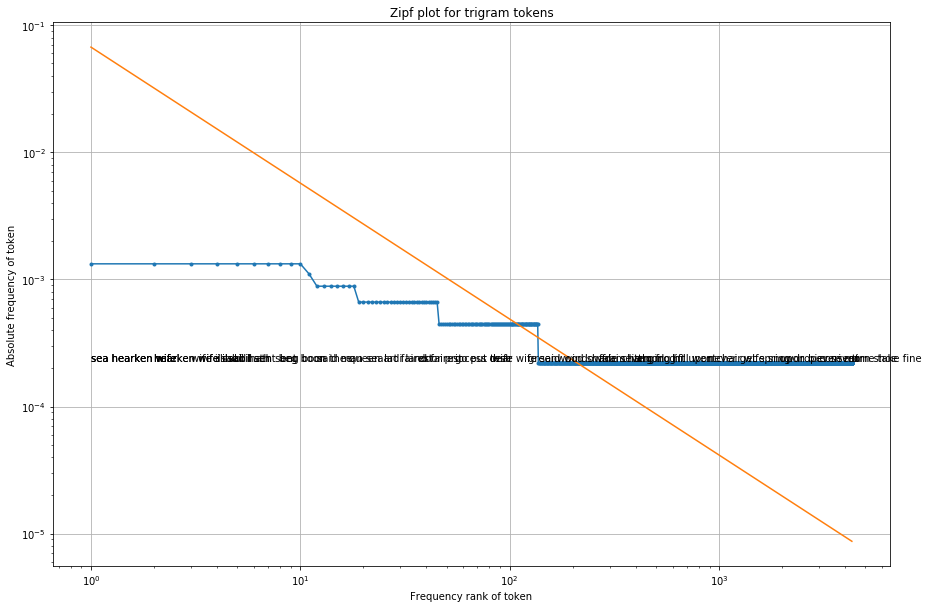

In [47]:
'''
Zipfian plot of trigrams
'''

#
counts = tg_df['count']

#get index number for each token
tokens = tg_df.index

ranks = arange(1, len(counts)+1)
indices = argsort(-counts)
frequencies = counts[indices]

norm_freq = frequencies/sum(counts)

plt.figure(figsize=(15,10))

loglog(ranks, norm_freq, marker=".")

plt.plot(ranks, [z for z in zipf.pmf(ranks, 1.07)])


title("Zipf plot for trigram tokens")
xlabel("Frequency rank of token")
ylabel("Absolute frequency of token")

grid(True)

last_freq = None

for n in list(logspace(-0.5, log10(len(counts)-2), 25).astype(int)):
    dummy = text(ranks[n], norm_freq[n], tg_df['ngram'].iloc[tokens[indices[n]]], 
                 verticalalignment="bottom",
                 horizontalalignment="left")

In [48]:
str_gram = []
freqls = []

#add 4-gram and frequency count to lists
for ngram, freq in FreqDist(all_fgs).items():
    
    str_gram.append(" ".join(ngram))
    freqls.append(freq)

In [49]:
#zip 4-gram and frequency lists
#combine into one list
fgls = list(zip(str_gram, freqls))

In [50]:
#create dataframe of 4-grams and frequency count
fg_df = pd.DataFrame(fgls, columns=['ngram', 'count'])
fg_df.head()

,ngram,count
0,twelv danc princess king,1
1,danc princess king twelv,1
2,princess king twelv beauti,1
3,king twelv beauti daughter,1
4,twelv beauti daughter slept,1


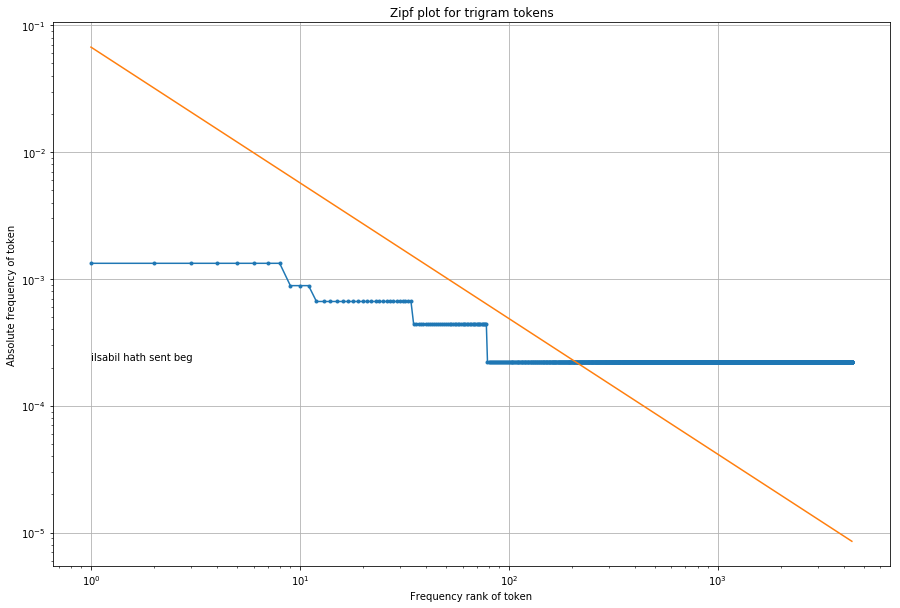

In [51]:
'''
Zipfian plot of 4-grams
'''

#
counts = fg_df['count']

#get index number for each token
tokens = fg_df.index

ranks = arange(1, len(counts)+1)
indices = argsort(-counts)
frequencies = counts[indices]

norm_freq = frequencies/sum(counts)

plt.figure(figsize=(15,10))

loglog(ranks, norm_freq, marker=".")

plt.plot(ranks, [z for z in zipf.pmf(ranks, 1.07)])


title("Zipf plot for trigram tokens")
xlabel("Frequency rank of token")
ylabel("Absolute frequency of token")

grid(True)

last_freq = None

for n in list(logspace(-0.5, log10(len(counts)-2), 25).astype(int)):
    if last_freq != norm_freq[n]:
        dummy = text(ranks[n], norm_freq[n], fg_df['ngram'].iloc[tokens[indices[n]]], 
                     verticalalignment="bottom",
                     horizontalalignment="left")
    last_freq = norm_freq[n]

## References:

[Week 3 assignment video walkthrough](https://www.youtube.com/watch?v=KwIp_73ndeI&feature=youtu.be)

Stemmers. Retrieved from http://www.nltk.org/howto/stem.html

SpaCy 101: Everything you need to know · spaCy Usage Documentation. Retrieved from https://spacy.io/usage/spacy-101

Towards Data Science. (2017, December 28). Another Twitter sentiment analysis with Python - Part 3 (Zipf's Law, data visualisation). Retrieved from https://towardsdatascience.com/another-twitter-sentiment-analysis-with-python-part-3-zipfs-law-data-visualisation-fc9eadda71e7

Word cloud with frequently occurring bigrams and salient bigrams. (2017, September 17). Retrieved from https://avidml.wordpress.com/2017/08/03/word-cloud-with-frequently-occurring-bigrams-and-salient-bigrams/

GoTrained. (2019, February 01). Edit Distance and Jaccard Distance Calculation with NLTK. Retrieved from https://python.gotrained.com/nltk-edit-distance-jaccard-distance/